In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('medicare-physician-and-other-supplier-national-provider-identifier-npi-aggregate-report-calendar-year-2016.csv', low_memory = False)
df2  = df.iloc[:,15:]



In [33]:
df2['National Provider Identifier'] = df['National Provider Identifier']
df2['Gender of the Provider'] = df['Gender of the Provider']
df2['cost_per_patient'] = df2['Total Medicare Payment Amount']/df2['Number of Medicare Beneficiaries']

# Wrangling Drug Information
In the cells below I import the medicare drug dataframe. As the dataframe includes specific information for each drug, I combine all rows for each doctor into one that includes the total cost of all drugs written and total number of 30 day prescriptions written. I do this using pandas groupy and sum function. Once this is completed the dataframe is merged with the dataframe of the patient demographic information for each physician. 

In [34]:
dr_costs = pd.read_pickle('df_dcost')
dr_costs.columns

Index(['npi', 'specialty_description', 'drug_name', 'generic_name',
       'total_30_day_fill_count', 'total_drug_cost'],
      dtype='object')

In [35]:
dr_costs.columns = ['National Provider Identifier', 'specialty_description', 'drug_name', 'generic_name',
       'total_30_day_fill_count', 'total_drug_cost']

In [36]:
dr_costs = dr_costs.drop(['drug_name', 'generic_name'], axis = 1)
dr_cost_drop = dr_costs.drop('specialty_description', axis = 1)
dr_cost_drop = dr_cost_drop.groupby('National Provider Identifier')
drug_sum = dr_cost_drop.sum()
drug_sum

,total_30_day_fill_count,total_drug_cost
National Provider Identifier,,
1003000126,319.0,20655.60
1003000142,1690.8,120865.38
1003000167,32.0,134.76
1003000282,30.0,328.04
1003000407,1742.2,86421.07
...,...,...
1992999825,220.2,7206.46
1992999833,35.0,624.65
1992999866,12.0,218.42


In [37]:
dr_costs = dr_costs.drop(['total_drug_cost', 'total_30_day_fill_count'], axis = 1)

In [38]:
print(dr_costs[:5])
dr_costs = dr_costs.drop_duplicates()
print(dr_costs.shape)

   National Provider Identifier specialty_description
0                    1003000126     Internal Medicine
1                    1003000126     Internal Medicine
2                    1003000126     Internal Medicine
3                    1003000126     Internal Medicine
4                    1003000126     Internal Medicine
(893160, 2)


In [39]:
print(drug_sum.columns)
print(drug_sum.head())
drug_sum = drug_sum.merge(dr_costs, how = 'inner', on = 'National Provider Identifier')

Index(['total_30_day_fill_count', 'total_drug_cost'], dtype='object')
                              total_30_day_fill_count  total_drug_cost
National Provider Identifier                                          
1003000126                                      319.0         20655.60
1003000142                                     1690.8        120865.38
1003000167                                       32.0           134.76
1003000282                                       30.0           328.04
1003000407                                     1742.2         86421.07


In [40]:
from collections import Counter
drug_sum_3k = drug_sum[drug_sum['total_30_day_fill_count']>=3000]
V_count = Counter(drug_sum_3k.specialty_description).most_common(10)
spec_list = []
for object in V_count:
    spec_list.append(object[0])
drug_sum= drug_sum[drug_sum.specialty_description.isin(spec_list)]


In [41]:
drug_sum['National Provider Identifier'] = drug_sum['National Provider Identifier'].astype(np.int64)


# Merge both dataframes
Below we merge the dataframe of the cumulative drug prescription info for each doctor and the dataframe of demographic information of doctors' patient populations.  Now we are able to perform machine learning to predict physicians' total drug costs from the all of the related variables that it was merged with.

In [42]:
df9 = drug_sum.merge(df2, how = 'inner', on = 'National Provider Identifier')
df9.head()

,National Provider Identifier,total_30_day_fill_count,total_drug_cost,specialty_description,Number of HCPCS,Number of Services,Number of Medicare Beneficiaries,Total Submitted Charge Amount,Total Medicare Allowed Amount,Total Medicare Payment Amount,...,Percent (%) of Beneficiaries Identified With Hyperlipidemia,Percent (%) of Beneficiaries Identified With Hypertension,Percent (%) of Beneficiaries Identified With Ischemic Heart Disease,Percent (%) of Beneficiaries Identified With Osteoporosis,Percent (%) of Beneficiaries Identified With Rheumatoid Arthritis / Osteoarthritis,Percent (%) of Beneficiaries Identified With Schizophrenia / Other Psychotic Disorders,Percent (%) of Beneficiaries Identified With Stroke,Average HCC Risk Score of Beneficiaries,Gender of the Provider,cost_per_patient
0,1003000126,319.0,20655.60,Internal Medicine,23,1477.0,518,746533.00,159958.60,124795.99,...,67.0,75.0,53.0,12.0,49.0,9.0,13.0,2.0239,M,240.918900
1,1003000407,1742.2,86421.07,Family Practice,31,1637.0,401,260033.00,179134.36,136143.38,...,69.0,75.0,64.0,15.0,43.0,12.0,14.0,2.0000,M,339.509676
2,1003000522,10084.4,208483.89,Family Practice,55,1952.0,417,368518.56,139319.81,106581.66,...,75.0,75.0,38.0,11.0,54.0,NaN,6.0,1.2619,M,255.591511
3,1003000530,9895.3,269677.82,Internal Medicine,25,1319.0,334,185183.00,124717.40,89429.84,...,62.0,67.0,29.0,5.0,27.0,3.0,NaN,1.0124,F,267.754012
4,1003000753,14.0,32.48,Physician Assistant,36,116.0,20,19587.98,5038.10,3525.33,...,NaN,75.0,0.0,0.0,NaN,0.0,0.0,1.0672,M,176.266500


# In the below cells I create a list of the ten most common medical specialties

In [43]:
from collections import Counter
V_count = Counter(df9.specialty_description).most_common(10)
index = 1
d = {} 
for name, count in V_count:
    d[name] = index
    index += 1
print(d)    
        
        

{'Internal Medicine': 1, 'Family Practice': 2, 'Nurse Practitioner': 3, 'Physician Assistant': 4, 'Psychiatry': 5, 'Cardiovascular Disease (Cardiology)': 6, 'Ophthalmology': 7, 'Neurology': 8, 'Endocrinology': 9, 'General Practice': 10}


# Copies of merged DataFrame in entirety
In the cell below I create copies fo the newly merged dataframe. I do this because I will be making modifications to the DataFrame to prepare it to be explored with Scikit Learn's algorithm's. However I want to be able to access the original dataframe so that I can use data exploration and plot visuals with all of the original data. 

In [44]:
spec_df = df9.copy()
spec_unfiltered_df = df9.copy()
print(type(spec_unfiltered_df))

<class 'pandas.core.frame.DataFrame'>


# Eliminating Features and Filtering out Rows
In the cells below I eliminate features which are missing to much information. Essentially these features have to many rows without real values and which have nan values instead. In addition I filter  out rows which have less than 44 features with real values that are not nan. There are a total of 52 features we are using. In essences rows which are missing over 17% of the used features are being removed from the dataset. 

The rows that we do keep but that have nan values are dealt with by the fillna function. We fill the nan values with the median values of their respective columns. 

In [45]:

df9 = df9.drop(['Number of Black or African American Beneficiaries','Number of Asian Pacific Islander Beneficiaries','Number of Hispanic Beneficiaries','Number of American Indian/Alaska Native Beneficiaries','Number of Beneficiaries With Race Not Elsewhere Classified','Medical Suppress Indicator','Drug Suppress Indicator'], axis = 1)

df44 = df9.dropna(thresh = 44 )
df44_fill = df44.fillna(df44.median())

In [46]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import functools


# Modifying Categorical Data
In the cell below there is a dictionary giving numerical values to keys representing gender. Using this the gender information is remapped to bivariate numerical representations. This is important because the machine learning algorithm's only with numerical data. 

Similarly in the cell directly below the gender mapping, I filter the dataframe to include the ten specialties with the most doctors who prescribed over 3,000 prescription for the year. I then created Dummy Variables for each specialty. Creating Dummy Variables is essential, the reason for this is that specialties are highly predictive of drug costs, and specialties also distinct and different relationships with other feature that are predictive of drug costs

In [47]:
df_fill = df44_fill
genderdict = {'M':1, 'F':0}
df_fill['Gender of the Provider'] = df_fill['Gender of the Provider'].map(genderdict)
df_fill.shape

(270787, 54)

In [105]:

from collections import Counter
df_fill = df_fill[df_fill['total_30_day_fill_count']>=3000]

V_count = Counter(spec_df.specialty_description).most_common(10)
spec_list = []
for object in V_count:
    spec_list.append(object[0])

top_spec = df_fill[df_fill.specialty_description.isin(spec_list)]
dummy_df = pd.get_dummies(top_spec['specialty_description'])
df_fill = pd.concat([top_spec,dummy_df], axis = 1)

In [106]:
drug_avg = df_fill.loc[:,['specialty_description','total_drug_cost']]

drug_avg = drug_avg.groupby(by ='specialty_description').median()
print(drug_avg)


                                     total_drug_cost
specialty_description                               
Cardiovascular Disease (Cardiology)       262932.300
Endocrinology                             868780.275
Family Practice                           259823.530
General Practice                          309071.070
Internal Medicine                         334609.560
Neurology                                 882919.930
Nurse Practitioner                        190779.090
Ophthalmology                             334678.410
Physician Assistant                       180961.030
Psychiatry                                359020.130


In [107]:
drug_avg = drug_avg.round()
drug_avg_dict = drug_avg.to_dict()

In [108]:
nested_dict = drug_avg['total_drug_cost']
nested_dict = nested_dict.to_dict()
df_fill['specialty_description_vector'] = df_fill['specialty_description'].map(nested_dict)

In [109]:
all_med = df_fill
all_med = all_med.drop('specialty_description', axis = 1)
all_med.shape

(114524, 74)

In [110]:
all_med = all_med.astype(np.float64)
all_med = all_med.fillna(all_med.median())
all_med = all_med[all_med['total_30_day_fill_count']>=3000]


C:\Users\Asus Laptop\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\Asus Laptop\Anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


# Random Sample/ GridSearchCV
In the cells below I created a random sample made up of 20% of the rows in the entire dataframe. I created a sample to use with GridSearchCV. The reason I did this is because the data set is very large and because Grid Search is running multie fold cross variable test for each potential combination in the parameter grid, it requires alot of time. As a means to make the data more manageable we only use a random 20%.

In [111]:
wall_med = all_med.sample(frac=0.2, replace=False, axis = 0)


In [112]:
from sklearn.ensemble import RandomForestRegressor

In [113]:
X = wall_med.drop('total_drug_cost', axis = 1)
y = wall_med.total_drug_cost


max_features = [30, 32]
max_depth = [25, 27] 

parameters = {'max_depth': max_depth, 'max_features' : max_features}

rf = RandomForestRegressor(n_estimators = 150)
clf = GridSearchCV(rf, param_grid = parameters, cv=3 )
clf.fit(X, y)
print(clf.best_params_)
b_estimator = clf.best_estimator_
print(b_estimator)

# Machine Learning
Below is the machine learning code for the dataset. After splitting the dataframe into a testing set and training set, I then ran random forest with the hyperparameters I found using GridSearchCV. My end prediction is annual drug costs for each physician. I also ran Gradient Search to determine which machine learning algorithm was more effective. 


In [114]:
X = all_med.drop('total_drug_cost', axis = 1)
#X = X_initial.drop('National Provider Identifier', axis = 1)
y = all_med.total_drug_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)


In [115]:
rf = RandomForestRegressor( n_estimators = 200, max_features = 30, max_depth = 25)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
rf_SCORE = rf.score(X_test, y_test)
print(rf_SCORE)

0.6643778980110564


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
learning_rate = [.02, .08,]
n_estimators = [200, 300]
max_depth = [ 25, 45]
#max_features = [20, 30, 40, None]

parameters = {'max_depth': max_depth, 'n_estimators' : n_estimators, 'max_depth' : max_depth}

gbt =GradientBoostingRegressor()
RS = GridSearchCV(gbt, param_distributions = parameters, cv=3 )
RS.fit(X, y)
print(RS.best_params_)
best_estimator = RS.best_estimator_
print(best_estimator)

In [139]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(learning_rate =.02, n_estimators = 300, max_depth = 7, max_features = 30)
gb.fit(X_train, y_train)
gb_y_pred = gb.predict(X_test)
gb_SCORE = gb.score(X_test, y_test)
print(gb_SCORE)

0.6768805390128219


max depth = 7, learnign rate .02, max features: 0.686

# Organizing/ Graphing Results
Here I created a data frame showing the cumulative distribution of doctors by how close they were to the predicted drug costs. 
I used the Counter container type to determine the total amount of doctors above and below a specific percentage above their predicted drug costs. I then turned the data into a dataframe that I could graph

In [144]:
from collections import Counter
cnt = Counter()

percent_dif = (gb_y_pred - y_test)/y_test

under_100_percent_dif = (percent_dif < 1).astype('int')
print(f' Under 100 percent:{under_100_percent_dif.value_counts()}')

index = 0
dict_perc = {}
for percent in range(100):
    cnt[0] = 0
    cnt[1] = 0
    perc =  (percent_dif < index).astype('int')
    for num in perc:
        cnt[num] += 1
    value = cnt[1]/(cnt[1]+cnt[0])
    dict_perc[index] = value
    index +=.02
Prescription_plot = pd.DataFrame.from_dict(dict_perc, orient = 'index')
Prescription_plot = Prescription_plot.reset_index()
Prescription_plot.columns = ['Percentage of predicted annual prescription costs','percentage of physicians below threshold']


    

 Under 100 percent:1    21757
0     1148
Name: total_drug_cost, dtype: int64


In [145]:
Prescription_plot

,Percentage of predicted annual prescription costs,percentage of physicians below threshold
0,0.00,0.390963
1,0.02,0.415761
2,0.04,0.442480
3,0.06,0.469417
4,0.08,0.492731
...,...,...
95,1.90,0.988780
96,1.92,0.989216
97,1.94,0.989391
98,1.96,0.989828


In [149]:
prescription_table = Prescription_plot.iloc[[10,20,30,40,50,60,70,80,99]]
prescription_table.columns = ['Percentage above predicted annual prescription costs', 'percentage of physicians below threshold']
prescription_table

,Percentage above predicted annual prescription costs,percentage of physicians below threshold
10,0.20,0.625409
20,0.40,0.785287
30,0.60,0.871993
40,0.80,0.921807
50,1.00,0.949880
60,1.20,0.965422
70,1.40,0.975769
80,1.60,0.982886
99,1.98,0.990133


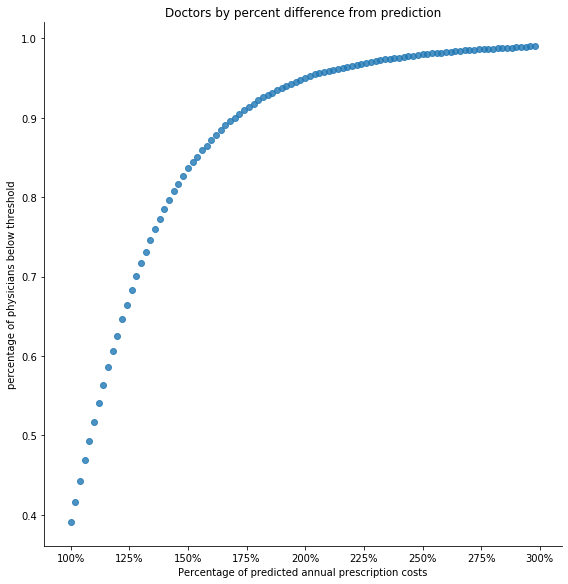

In [150]:
import seaborn as sns

sns.lmplot(x = 'Percentage of predicted annual prescription costs', y ='percentage of physicians below threshold', data = Prescription_plot, fit_reg = False,  aspect=1, height=8)
plt.xticks( ticks = [0.00,0.25,0.50,0.75,1.00, 1.25,1.50,1.75,2.00], labels= ['100%', '125%', '150%', '175%', '200%', '225%', '250%', '275%','300%'] )
plt.title('Doctors by percent difference from prediction')
plt.savefig('doctors by percent difference from prediction.png')

# Graphic Plots
Below I write code to get a dataframe including the 15 most common specialties. Then create plots showing the relationship's between average prescription cost for specific specialties and the specialists' percentage of patients with specific chronic illness. I also create a plot that simply shows the distribution and range of the average prescriptions costs across the most common specialties. 

In [157]:
from collections import Counter
spec_df = spec_df[spec_df['total_30_day_fill_count']>=3000]

HCC_df = spec_df.copy()
spec_df = spec_df[spec_df['specialty_description']!= 'Nurse Practitioner']
spec_df = spec_df[spec_df['specialty_description']!= 'Physician Assistant']
spec_df = spec_df[spec_df['specialty_description']!= 'Orthopedic Surgery']
V_count = Counter(spec_df.specialty_description).most_common(20)
print(V_count)
spec_list = V_count[0]
spec_list = []
for object in V_count:
    spec_list.append(object[0])
print(spec_list)

top_spec = spec_df[spec_df.specialty_description.isin(spec_list)]
top_spec['cost_per_prescription'] = top_spec['total_drug_cost']/ top_spec['total_30_day_fill_count']
HCC_df['cost_per_prescription'] = top_spec['total_drug_cost']/ top_spec['total_30_day_fill_count']
spec_unfiltered_df['cost_per_prescription'] = spec_unfiltered_df['total_drug_cost']/ spec_unfiltered_df['total_30_day_fill_count']

top_spec.head()
print(spec_list)
top_spec


[('Family Practice', 47570), ('Internal Medicine', 43847), ('Cardiovascular Disease (Cardiology)', 12206), ('Psychiatry', 4911), ('Ophthalmology', 3598), ('Neurology', 3166), ('Endocrinology', 2835), ('General Practice', 2644)]
['Family Practice', 'Internal Medicine', 'Cardiovascular Disease (Cardiology)', 'Psychiatry', 'Ophthalmology', 'Neurology', 'Endocrinology', 'General Practice']
['Family Practice', 'Internal Medicine', 'Cardiovascular Disease (Cardiology)', 'Psychiatry', 'Ophthalmology', 'Neurology', 'Endocrinology', 'General Practice']


,National Provider Identifier,total_30_day_fill_count,total_drug_cost,specialty_description,Number of HCPCS,Number of Services,Number of Medicare Beneficiaries,Total Submitted Charge Amount,Total Medicare Allowed Amount,Total Medicare Payment Amount,...,Percent (%) of Beneficiaries Identified With Hypertension,Percent (%) of Beneficiaries Identified With Ischemic Heart Disease,Percent (%) of Beneficiaries Identified With Osteoporosis,Percent (%) of Beneficiaries Identified With Rheumatoid Arthritis / Osteoarthritis,Percent (%) of Beneficiaries Identified With Schizophrenia / Other Psychotic Disorders,Percent (%) of Beneficiaries Identified With Stroke,Average HCC Risk Score of Beneficiaries,Gender of the Provider,cost_per_patient,cost_per_prescription
2,1003000522,10084.4,208483.89,Family Practice,55,1952.0,417,368518.56,139319.81,106581.66,...,75.0,38.0,11.0,54.0,NaN,6.0,1.2619,M,255.591511,20.673901
3,1003000530,9895.3,269677.82,Internal Medicine,25,1319.0,334,185183.00,124717.40,89429.84,...,67.0,29.0,5.0,27.0,3.0,NaN,1.0124,F,267.754012,27.253122
5,1003000902,9005.6,204088.52,Family Practice,35,916.0,258,106047.00,59687.40,40810.00,...,70.0,25.0,7.0,41.0,5.0,NaN,1.2416,F,158.178295,22.662401
6,1003000936,3061.0,137785.22,Internal Medicine,68,4670.0,1374,565333.00,278921.17,208615.23,...,75.0,65.0,6.0,48.0,4.0,12.0,1.8353,M,151.830590,45.013139
8,1003001884,4713.7,55843.47,Family Practice,42,640.0,145,63048.00,42913.01,34374.93,...,71.0,35.0,8.0,44.0,NaN,NaN,1.1660,F,237.068483,11.847056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375049,1992996375,3454.4,878740.46,Internal Medicine,48,3987.0,417,250353.00,118527.76,88108.13,...,75.0,44.0,13.0,45.0,3.0,5.0,1.9668,F,211.290480,254.382949
375056,1992997647,6233.1,192166.48,Family Practice,6,73.0,22,10971.00,6681.43,5133.62,...,75.0,NaN,NaN,NaN,NaN,0.0,2.0573,M,233.346364,30.830001
375058,1992998645,8805.7,241994.80,Internal Medicine,32,4164.0,562,1111256.00,363839.24,282301.54,...,75.0,50.0,11.0,44.0,4.0,14.0,2.2050,F,502.315907,27.481609
375060,1992999122,24736.9,732161.58,Internal Medicine,51,7991.0,1398,821639.00,602725.38,461352.08,...,72.0,49.0,11.0,47.0,1.0,6.0,1.3262,M,330.008641,29.597952


In [154]:
HCC_df

,National Provider Identifier,total_30_day_fill_count,total_drug_cost,specialty_description,Number of HCPCS,Number of Services,Number of Medicare Beneficiaries,Total Submitted Charge Amount,Total Medicare Allowed Amount,Total Medicare Payment Amount,...,Percent (%) of Beneficiaries Identified With Hypertension,Percent (%) of Beneficiaries Identified With Ischemic Heart Disease,Percent (%) of Beneficiaries Identified With Osteoporosis,Percent (%) of Beneficiaries Identified With Rheumatoid Arthritis / Osteoarthritis,Percent (%) of Beneficiaries Identified With Schizophrenia / Other Psychotic Disorders,Percent (%) of Beneficiaries Identified With Stroke,Average HCC Risk Score of Beneficiaries,Gender of the Provider,cost_per_patient,cost_per_prescription
2,1003000522,10084.4,208483.89,Family Practice,55,1952.0,417,368518.56,139319.81,106581.66,...,75.0,38.0,11.0,54.0,NaN,6.0,1.2619,M,255.591511,20.673901
3,1003000530,9895.3,269677.82,Internal Medicine,25,1319.0,334,185183.00,124717.40,89429.84,...,67.0,29.0,5.0,27.0,3.0,NaN,1.0124,F,267.754012,27.253122
5,1003000902,9005.6,204088.52,Family Practice,35,916.0,258,106047.00,59687.40,40810.00,...,70.0,25.0,7.0,41.0,5.0,NaN,1.2416,F,158.178295,22.662401
6,1003000936,3061.0,137785.22,Internal Medicine,68,4670.0,1374,565333.00,278921.17,208615.23,...,75.0,65.0,6.0,48.0,4.0,12.0,1.8353,M,151.830590,45.013139
8,1003001884,4713.7,55843.47,Family Practice,42,640.0,145,63048.00,42913.01,34374.93,...,71.0,35.0,8.0,44.0,NaN,NaN,1.1660,F,237.068483,11.847056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375051,1992996912,33362.2,1619061.15,Nurse Practitioner,35,1038.0,339,92353.00,53920.49,36322.31,...,73.0,55.0,10.0,42.0,8.0,8.0,1.5937,M,107.145457,NaN
375056,1992997647,6233.1,192166.48,Family Practice,6,73.0,22,10971.00,6681.43,5133.62,...,75.0,NaN,NaN,NaN,NaN,0.0,2.0573,M,233.346364,30.830001
375058,1992998645,8805.7,241994.80,Internal Medicine,32,4164.0,562,1111256.00,363839.24,282301.54,...,75.0,50.0,11.0,44.0,4.0,14.0,2.2050,F,502.315907,27.481609
375060,1992999122,24736.9,732161.58,Internal Medicine,51,7991.0,1398,821639.00,602725.38,461352.08,...,72.0,49.0,11.0,47.0,1.0,6.0,1.3262,M,330.008641,29.597952


(0, 300)

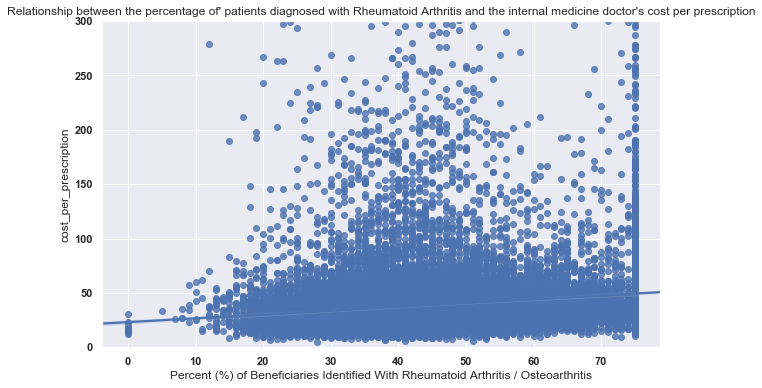

In [158]:
HCC_PCP_df = HCC_df[HCC_df['specialty_description'] == 'Internal Medicine']

sns.set(rc={'figure.figsize':(10,6)})
sns.regplot(x = 'Percent (%) of Beneficiaries Identified With Rheumatoid Arthritis / Osteoarthritis', y = 'cost_per_prescription', data = HCC_PCP_df )
plt.title("Relationship between the percentage of' patients diagnosed with Rheumatoid Arthritis and the internal medicine doctor's cost per prescription")
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.ylim(0, 300)   

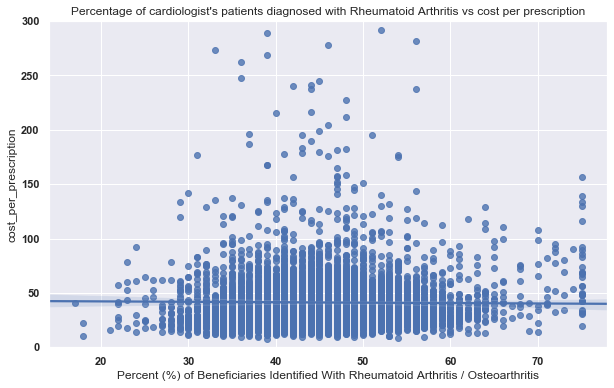

In [159]:
HCC_cardio_df = HCC_df[HCC_df['specialty_description'] == 'Cardiovascular Disease (Cardiology)']

sns.set(rc={'figure.figsize':(10,6)})
sns.regplot(x = 'Percent (%) of Beneficiaries Identified With Rheumatoid Arthritis / Osteoarthritis', y = 'cost_per_prescription', data = HCC_cardio_df )
plt.title("Percentage of cardiologist's patients diagnosed with Rheumatoid Arthritis vs cost per prescription")
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.ylim(0, 300)
plt.savefig('Cardiology_Arthritis.png')

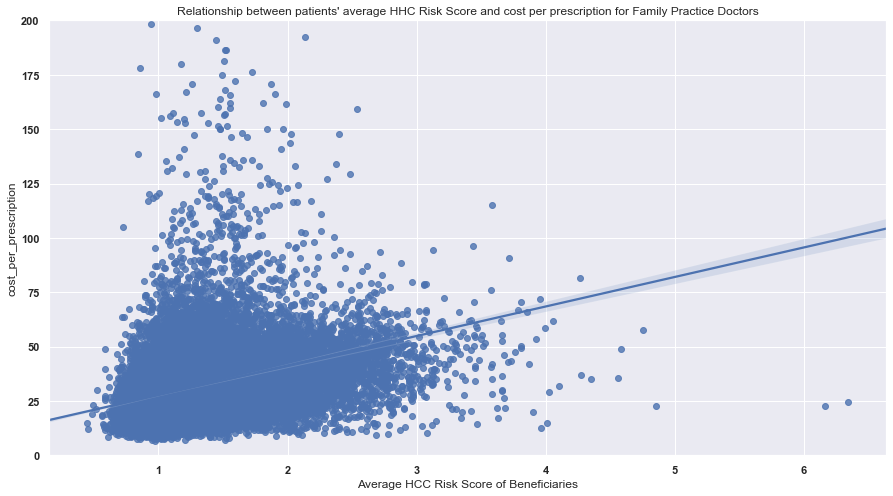

In [160]:
HCC_fp_df = HCC_df[HCC_df['specialty_description'] == 'Family Practice']

sns.set(rc={'figure.figsize':(15,8)})
sns.regplot(x = 'Average HCC Risk Score of Beneficiaries', y = 'cost_per_prescription', data = HCC_fp_df )
plt.ylim(0, 200)
plt.ylim(0, 200)
#sns.set(font_scale=5)
plt.title("Relationship between patients' average HHC Risk Score and cost per prescription for Family Practice Doctors")
plt.savefig('fp_HCC_SCORE.png')
plt.show()

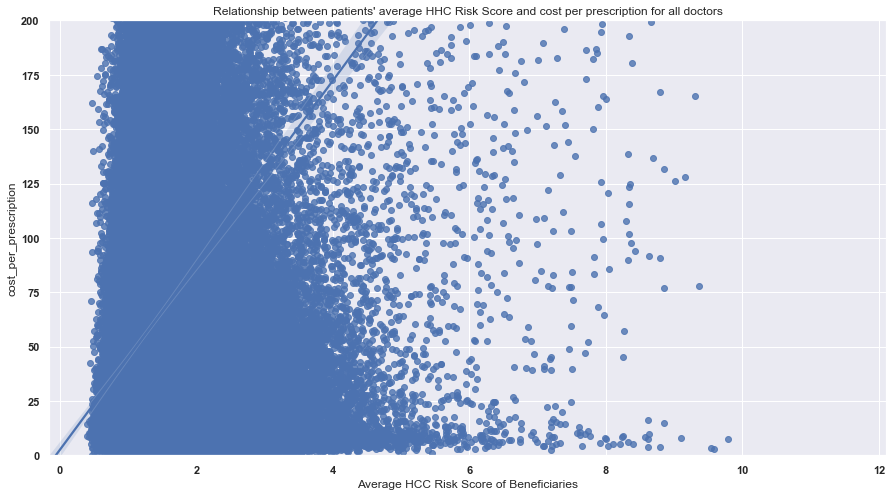

In [161]:
sns.set(rc={'figure.figsize':(15,8)})
sns.regplot(x = 'Average HCC Risk Score of Beneficiaries', y = 'cost_per_prescription', data = spec_unfiltered_df )
plt.ylim(0, 400)
plt.ylim(0, 200)
#sns.set(font_scale=5)
plt.title("Relationship between patients' average HHC Risk Score and cost per prescription for all doctors")
plt.savefig('All_docs_HCC_SCORE.png')
plt.show()

Text(0.5, 1.0, 'Average Prescription drug cost by number of prescriptions written')

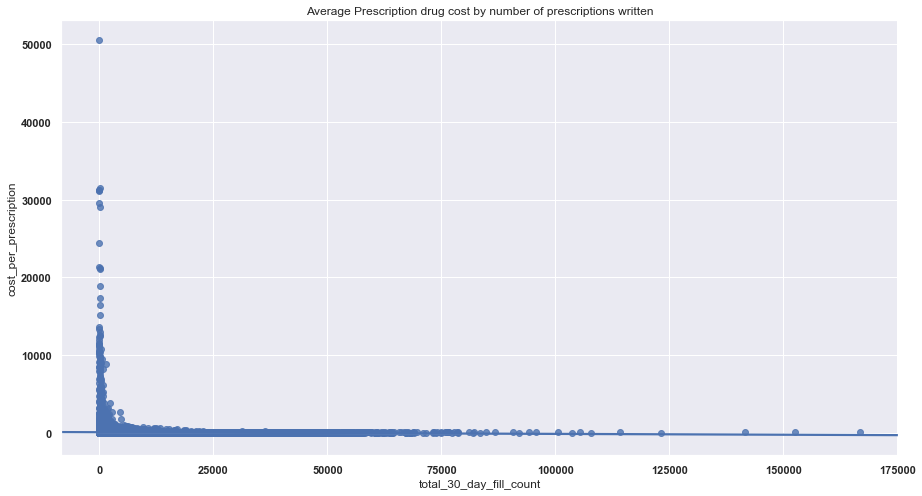

In [163]:
Int_unfiltered_df = spec_unfiltered_df[spec_unfiltered_df['specialty_description'] == 'Internal Medicine']
sns.regplot(Int_unfiltered_df['total_30_day_fill_count'],Int_unfiltered_df['cost_per_prescription'], scatter = True, fit_reg= True)
plt.title('Average Prescription drug cost by number of prescriptions written')

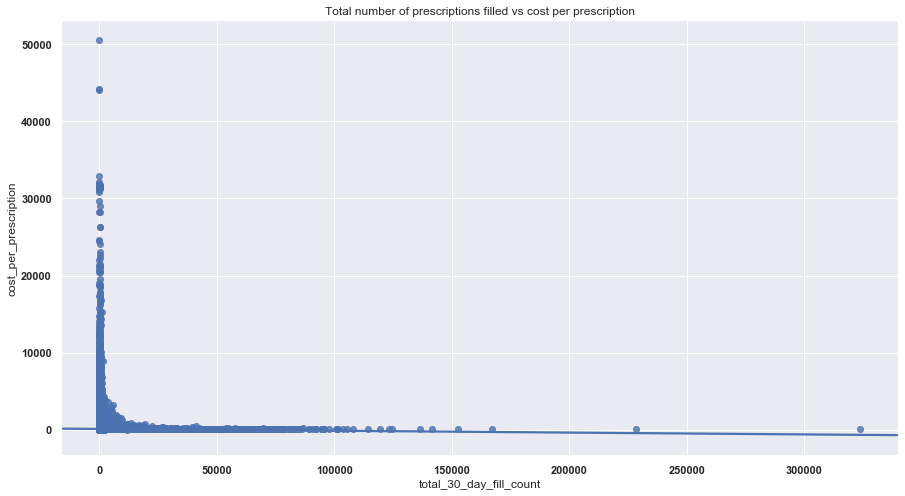

In [164]:

sns.regplot(spec_unfiltered_df['total_30_day_fill_count'],spec_unfiltered_df['cost_per_prescription'], scatter = True, fit_reg= True)
plt.title('Total number of prescriptions filled vs cost per prescription')
plt.savefig('number_of_prescriptions_vs_avg_cost')
plt.show()